In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import json
import time

import matplotlib.pyplot as plt
import umap.umap_ as umap
import torch
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from utils import get_digit_and_unit
from model import NumericOperationDataset, NumericalNet

2024-04-07 03:39:20.908483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 03:39:21.626998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = "/workspace/Data/NumericalNet/20240406_numerical_dataset_v2_40000.xlsx"
# data_path = "/workspace/Data/NumericalNet/20240406_numerical_dataset_v2_110000.xlsx"

data = pd.read_excel(data_path, engine="openpyxl")
data

,value1,unit1,operation,diff_value,diff_unit,value2,unit2
0,47120.4200,cm,+,1893.0000,cm,49013.4200,cm
1,63045.1900,cm,-,0.0000,cm,630.4519,m
2,773.0612,m,-,3155.3000,cm,741.5082,m
3,31.5104,m,+,3.2078,m,34718.2000,mm
4,54.0994,m,+,3.2409,m,57340.3000,mm
...,...,...,...,...,...,...,...
39995,1854.0000,year,+,501.0000,year,2355.0000,year
39996,1061.0000,year,+,484.0000,year,1545.0000,year
39997,1711.0000,year,+,717.0000,year,2428.0000,year
39998,565.0000,year,+,61.0000,year,626.0000,year


In [3]:
# target_units = list(set(data['unit1'] + data['unit2'] + data['diff_unit']))
target_units = list(set(data['unit1'].tolist() + data['unit2'].tolist() + data['diff_unit'].tolist()))
target_units = sorted(target_units, key=lambda x: x[-1])
unit_to_idx = {unit: idx for idx, unit in enumerate(target_units)}

target_operations = ["+", "-"]
operation_to_idx = {op: idx for idx, op in enumerate(target_operations)}

dataset = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    value1 = row['value1']
    unit1 = row['unit1']
    value2 = row['value2']
    unit2 = row['unit2']
    diff_value = row['diff_value']
    diff_unit = row['diff_unit']
    operation = row['operation']
    
    if diff_value == 0:
        equal = 1
    else:
        equal = 0
    
    dataset.append([value1, unit1, value2, unit2, diff_value, diff_unit, operation, equal])
    
print("Complete Preprocessing")

100%|██████████| 40000/40000 [00:02<00:00, 18740.95it/s]

Complete Preprocessing


In [4]:
# Hyperparameters
train_batch_size = 1024
test_batch_size = 256
num_epochs = 50
num_warmup_steps = 500
early_stopping_patience = 5
test_ratio = 0.1
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0005
weight_decay=2e-5
lr_scheduler = "cosine"

# Split the data into train and validation
train_dataset, valid_dataset = train_test_split(dataset, test_size=test_ratio, random_state=seed)
tr_ds = NumericOperationDataset(train_dataset, unit_to_idx, operation_to_idx)
val_ds = NumericOperationDataset(valid_dataset, unit_to_idx, operation_to_idx)
tr_dl = DataLoader(tr_ds, batch_size=train_batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=test_batch_size, shuffle=False)

# Model, Optimizer, Scheduler
model = NumericalNet(unit_to_idx, operation_to_idx, device, num_layers=8).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=weight_decay
)
num_training_steps = len(tr_dl) * num_epochs
scheduler = get_scheduler(
    name=lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [5]:
# Training
counter, best_loss = 0, float('inf')
train_losses, valid_losses = [], []

for idx, epoch in enumerate(range(num_epochs)):
    model.train()
    train_loss = 0.0
    start = time.time()
    for batch in tr_dl:
        batch = [tensor.to(device) for tensor in batch]
        value1, unit1, value2, unit2, diff_value, diff_unit, operation, equal = batch
        value1_unit1_embedding = model(value1, unit1)
        value2_unit2_embedding = model(value2, unit2)
        diff_value_unit_embedding = model(diff_value, diff_unit)

        loss = model.loss_fn(
            value1_unit1_embedding, 
            diff_value_unit_embedding,
            value2_unit2_embedding,
            operation,
            equal
        )

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    train_loss /= len(tr_dl)
    train_losses.append(train_loss)
    
    # Validation    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dl:
            batch = [tensor.to(device) for tensor in batch]
            value1, unit1, value2, unit2, diff_value, diff_unit, operation, equal = batch
            value1_unit1_embedding = model(value1, unit1)
            value2_unit2_embedding = model(value2, unit2)
            diff_value_unit_embedding = model(diff_value, diff_unit)

            loss = model.loss_fn(
                value1_unit1_embedding, 
                diff_value_unit_embedding,
                value2_unit2_embedding,
                operation,
                equal
            )
            val_loss += loss.item()

        val_loss /= len(val_dl)
        valid_losses.append(val_loss)

    elapsed = (time.time() - start)*1000
    if (epoch+1) % 1 == 0:
        print(f"Epoch[{epoch+1}/{num_epochs}]|LR: {optimizer.param_groups[0]['lr']:.6f}|Train Loss: {train_loss:.6f}|Val Loss: {val_loss:.6f}|Elapsed time: {elapsed:.2f}ms")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        best_epoch = epoch
    else:
        counter += 1
        if counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
# load the best model
model.load_state_dict(torch.load('best_model.pth'))
if os.path.exists('best_model.pth'):
    os.remove('best_model.pth')

print(f"\nBest model loaded with validation loss: {best_loss} at epoch {best_epoch+1}")

Epoch[1/50]|LR: 0.000036|Train Loss: 0.005633|Val Loss: 0.003994|Elapsed time: 4246.71ms
Epoch[2/50]|LR: 0.000072|Train Loss: 0.002064|Val Loss: 0.000429|Elapsed time: 3396.49ms
Epoch[3/50]|LR: 0.000108|Train Loss: 0.000087|Val Loss: 0.000008|Elapsed time: 3199.48ms
Epoch[4/50]|LR: 0.000144|Train Loss: 0.000002|Val Loss: 0.000000|Elapsed time: 3243.79ms
Epoch[5/50]|LR: 0.000180|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3410.32ms
Epoch[6/50]|LR: 0.000216|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3629.43ms
Epoch[7/50]|LR: 0.000252|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3409.00ms
Epoch[8/50]|LR: 0.000288|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3573.09ms
Epoch[9/50]|LR: 0.000324|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3349.46ms
Epoch[10/50]|LR: 0.000360|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3402.50ms
Epoch[11/50]|LR: 0.000396|Train Loss: 0.000000|Val Loss: 0.000000|Elapsed time: 3293.89ms
Epoch[12/50]|LR: 0.

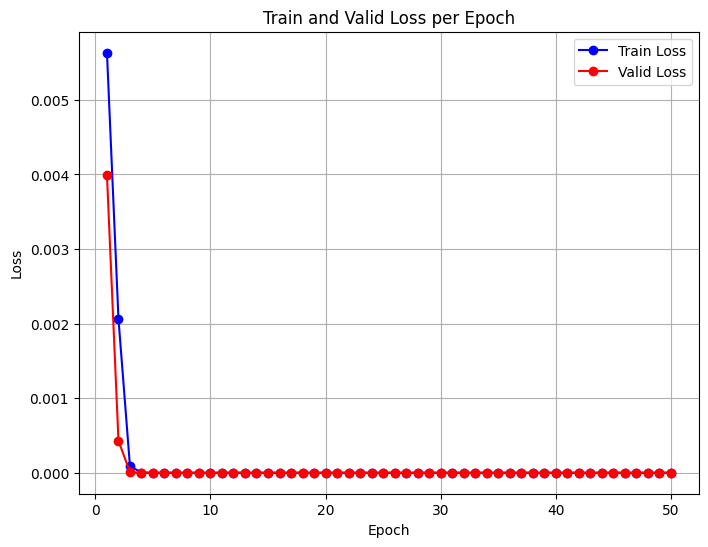

In [7]:
def plot_loss(train_losses, valid_losses, title="Train and Valid Loss per Epoch"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.plot(epochs, valid_losses, marker='o', linestyle='-', color='r', label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_loss(train_losses, valid_losses)

In [15]:
output_path = "../output/20240406_numericalnet_small_dim200"
os.makedirs(output_path, exist_ok=True)

unit_to_idx_path = os.path.join(output_path, "unit_to_idx.json")
with open(unit_to_idx_path, "w") as f:
    json.dump(unit_to_idx, f, indent=4, ensure_ascii=False)
    
operation_to_idx_path = os.path.join(output_path, "operation_to_idx.json")
with open(operation_to_idx_path, "w") as f:
    json.dump(operation_to_idx, f, indent=4, ensure_ascii=False)

torch.save(model.state_dict(), os.path.join(output_path, "best_model.pth"))
print(f"Compete saving the trained model")

Compete saving the trained model


## Visualization

In [8]:
def get_numeric_range(start, end, step, device=device):
    numeric_range = torch.arange(start, end, step, dtype=torch.float32).view(-1, 1).to(device)
    return numeric_range

def get_numeric_embeddings(model, device, start=0, end=10, step=0.1):
    numeric_range = torch.arange(start, end, step, dtype=torch.float32).view(-1, 1).to(device)
    with torch.no_grad():
        numeric_embeddings = model.get_digit_embedding(numeric_range)

    numeric_embeddings = numeric_embeddings.squeeze(1)
    return numeric_embeddings.cpu().numpy()

def get_unit_embeddings(unit, unit_to_idx, model=model, device=device):
    with torch.no_grad():
        unit_idx = torch.tensor(unit_to_idx[unit]).to(device)
        unit_embedding = model.get_unit_embedding(unit_idx).cpu().numpy()
    return unit_embedding

def get_numeric_unit_embedding(digit, unit, model=model, device=device):
    with torch.no_grad():
        joint_embedding = model(digit, unit)
    return joint_embedding

def apply_umap(embeddings, n_components=2):
    umap_model = umap.UMAP(n_components=n_components)
    reduced = umap_model.fit_transform(embeddings)
    return reduced

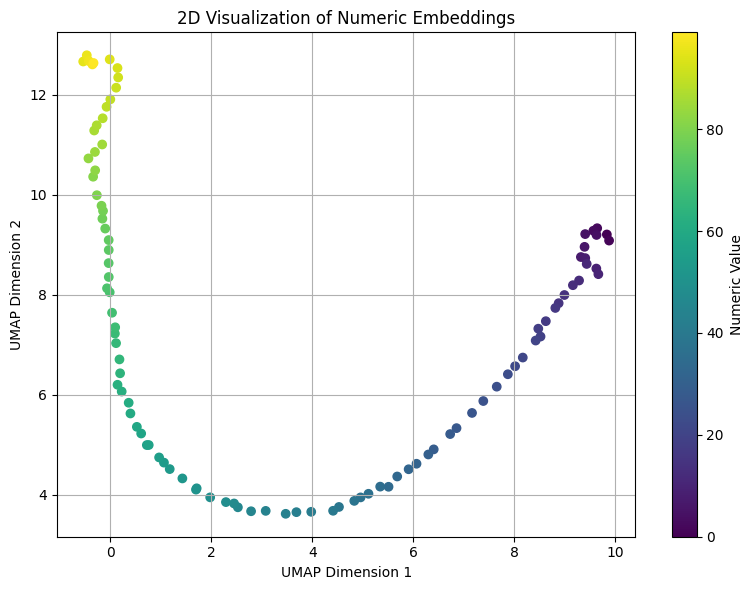

In [9]:
start, end, step = 0, 100, 1
numeric_embeddings_0_to_100 = get_numeric_embeddings(model, device, start, end, step)
numeric_embeddings_2d = apply_umap(numeric_embeddings_0_to_100)

plt.figure(figsize=(8, 6))
plt.scatter(numeric_embeddings_2d[:, 0], numeric_embeddings_2d[:, 1], c=np.arange(start, end, step), cmap='viridis')
plt.colorbar(label='Numeric Value')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


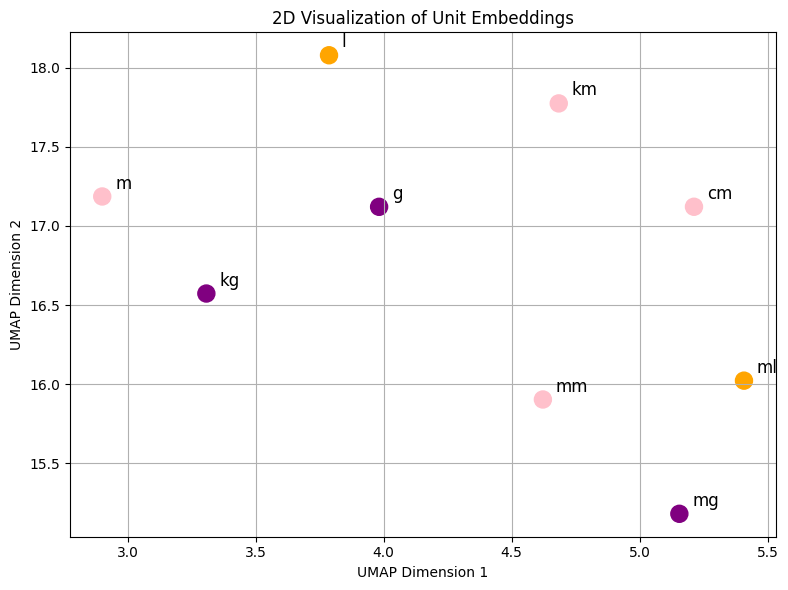

In [10]:
# units= ['g', 'mg', 'kg', 'ml', 'l', 'cm', 'km', 'mm', 'm']
units = ['g', 'kg', 'mg', 'ml', 'l', 'm', 'km', 'mm', 'cm']
colors = ['purple', 'purple', 'purple', 'orange', 'orange', 'pink', 'pink', 'pink', 'pink']

# Get unit_embeddings
unit_embeddings = []
for unit in units:
    unit_embeddings.append(get_unit_embeddings(unit, unit_to_idx, model, device))
unit_embeddings_2d = apply_umap(unit_embeddings)

# Create a scatter plot for unit embeddings with labels
plt.figure(figsize=(8, 6))
plt.scatter(unit_embeddings_2d[:, 0], unit_embeddings_2d[:, 1], c=colors[:len(units)], marker='o', s=150)

# Add labels for each unit embedding
for i in range(len(units)):
    plt.text(unit_embeddings_2d[i, 0]+0.05, unit_embeddings_2d[i, 1]+0.05, units[i], fontsize=12)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Unit Embeddings')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6571/2010954183.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(digit_unit_ranges))
/tmp/ipykernel_6571/2010954183.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


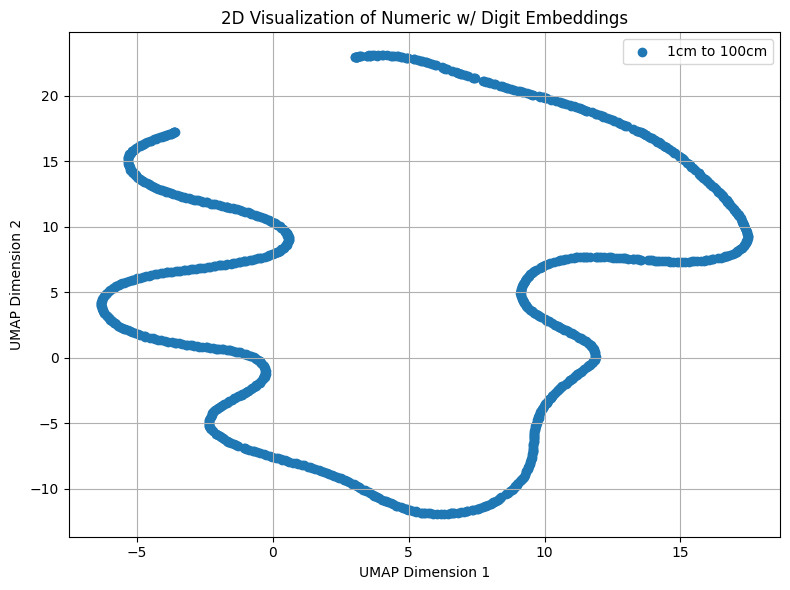

In [11]:
digit_unit_ranges = [
    ("cm", 1, 100, 0.1),
]

numeric_digit_embeddings = []
numeric_digit_labels = []
with torch.no_grad():
    for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
        temp_digit_unit_range = get_numeric_range(start, end, step)
        for digit in temp_digit_unit_range:
            temp_embedding = model(digit, unit).unsqueeze(0)
            numeric_digit_embeddings.append(temp_embedding.cpu().numpy())
        numeric_digit_labels.append(np.ones(len(temp_digit_unit_range))*idx)

embeddings = np.concatenate(numeric_digit_embeddings)
embeddings_2d = apply_umap(embeddings)
labels = np.concatenate(numeric_digit_labels)
unique_labels = np.unique(labels)
labels_text = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(digit_unit_ranges))
colors = [cmap(i) for i in range(len(digit_unit_ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric w/ Digit Embeddings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Advanced Visualization

/tmp/ipykernel_6571/1403385091.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(ranges))
/tmp/ipykernel_6571/1403385091.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


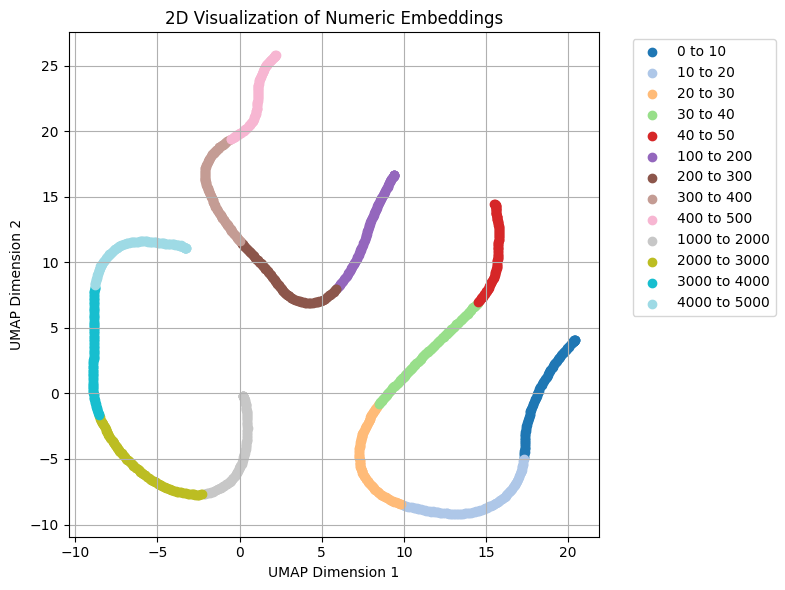

In [12]:
ranges = [
    (0, 10, 0.1),
    (10, 20, 0.1),
    (20, 30, 0.1),
    (30, 40, 0.1),
    (40, 50, 0.1),
    (100, 200, 1),
    (200, 300, 1),
    (300, 400, 1),
    (400, 500, 1),
    (1000, 2000, 10),
    (2000, 3000, 10),
    (3000, 4000, 10),
    (4000, 5000, 10)
]

# Generate embeddings for each range
numeric_embeddings = [get_numeric_embeddings(model, device, start, end, step) for start, end, step in ranges]
embeddings = np.concatenate(numeric_embeddings)
embeddings_2d = apply_umap(embeddings)

# Generate labels for each range
labels_list = []
for i, embeddings in enumerate(numeric_embeddings):
    labels_list.append(np.ones(embeddings.shape[0]) * i)
labels = np.concatenate(labels_list)
unique_labels = np.unique(labels)
labels_text = [f'{x[0]} to {x[1]}' for x in ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(ranges))
colors = [cmap(i) for i in range(len(ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6571/180045659.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(ranges))
/tmp/ipykernel_6571/180045659.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


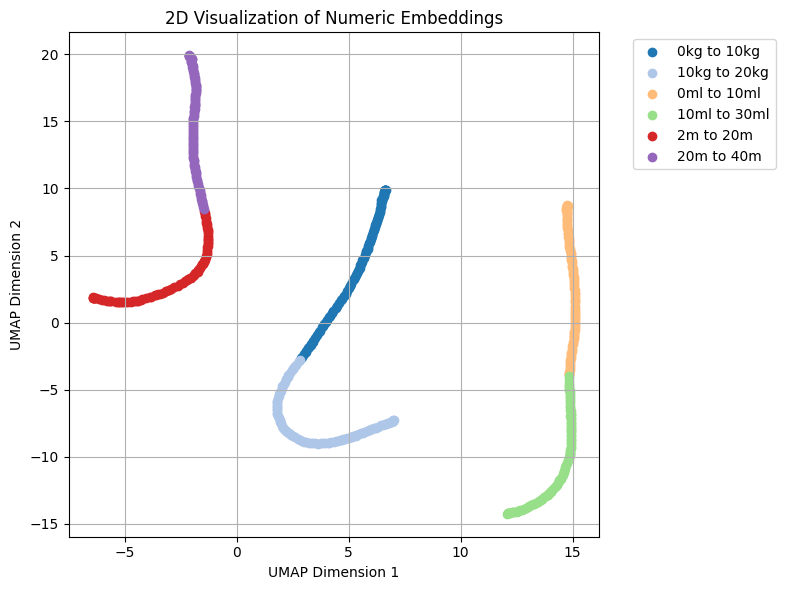

In [13]:
digit_unit_ranges = [
    ("kg", 0, 10, 0.1),
    ("kg", 10, 20, 0.1),
    ("ml", 0, 10, 0.1),
    ("ml", 10, 30, 0.2),
    ("m", 2, 20, 0.2),
    ("m", 20, 40, 0.2),
]

numeric_digit_embeddings = []
numeric_digit_labels = []
with torch.no_grad():
    for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
        temp_digit_unit_range = get_numeric_range(start, end, step)
        for digit in temp_digit_unit_range:
            temp_embedding = model(digit, unit)
            temp_embedding = temp_embedding.unsqueeze(0)
            numeric_digit_embeddings.append(temp_embedding.cpu().numpy())
        numeric_digit_labels.append(np.ones(len(temp_digit_unit_range))*idx)

embeddings = np.concatenate(numeric_digit_embeddings)
embeddings_2d = apply_umap(embeddings)
labels = np.concatenate(numeric_digit_labels)
unique_labels = np.unique(labels)
labels_text = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(ranges))
colors = [cmap(i) for i in range(len(ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6571/1566466974.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(ranges))
/tmp/ipykernel_6571/1566466974.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


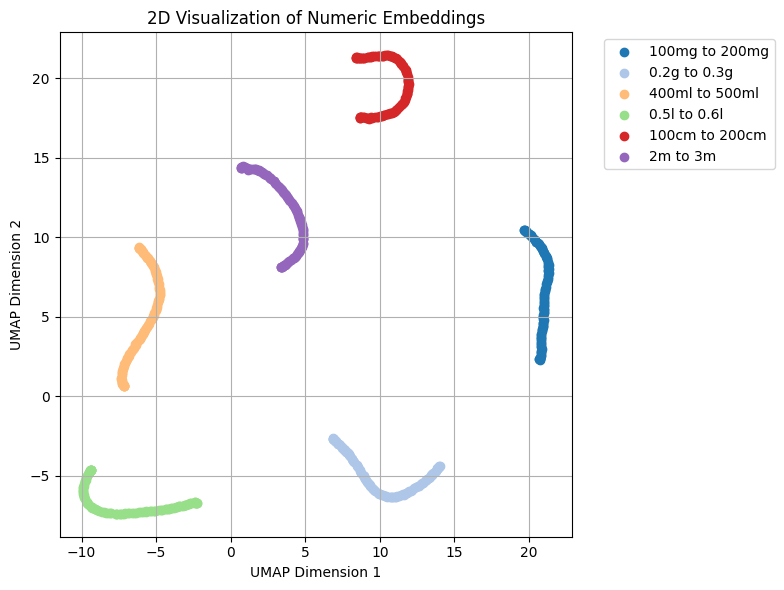

In [14]:
digit_unit_ranges = [
    ("mg", 100, 200, 1),
    ("g", 0.2, 0.3, 0.001),
    ("ml", 400, 500, 1),
    ("l", 0.5, 0.6, 0.001),
    ("cm", 100, 200, 1),
    ("m", 2, 3, 0.01),
]

numeric_digit_embeddings = []
numeric_digit_labels = []
with torch.no_grad():
    for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
        temp_digit_unit_range = get_numeric_range(start, end, step)
        for digit in temp_digit_unit_range:
            temp_embedding = model(digit, unit)
            temp_embedding = temp_embedding.unsqueeze(0)
            numeric_digit_embeddings.append(temp_embedding.cpu().numpy())
        numeric_digit_labels.append(np.ones(len(temp_digit_unit_range))*idx)

embeddings = np.concatenate(numeric_digit_embeddings)
embeddings_2d = apply_umap(embeddings)
labels = np.concatenate(numeric_digit_labels)
unique_labels = np.unique(labels)
labels_text = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(ranges))
colors = [cmap(i) for i in range(len(ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Distance Check

In [14]:
# 2m, 200cm, 1.9m, 190cm, 1.8m, 1.95m

with torch.no_grad():
    digit, unit = 2, "m"
    embedding_2m = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    digit, unit = 1.9, "m"
    embedding_1_9m = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    digit, unit = 1.8, "m"
    embedding_1_8m = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    digit, unit = 200, "cm"
    embedding_200cm = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    digit, unit = 190, "cm"
    embedding_190cm = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    digit, unit = 1.95, "m"
    embedding_1_95m = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    digit, unit = 42, 'ml'
    embedding_42ml = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    # 1.4m
    digit, unit = 1.4, 'm'
    embedding_1_4m = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    # 0.0m
    digit, unit = 0.0, 'm'
    embedding_0m = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    # 0.0cm
    digit, unit = 0.0, 'cm'
    embedding_0cm = model(digit, unit).unsqueeze(0).cpu()#.numpy()
    
    # 0.05m
    digit, unit = 0.05, 'm'
    embedding_0_05m = model(digit, unit).unsqueeze(0).cpu()#.numpy()

In [15]:

# 2m vs 1.95m, 2m vs 1.9m, 2m vs 1.8m

diff_2m_1_95m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_95m)
diff_2m_1_9m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_9m)
diff_2m_1_8m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_8m)
diff_2m_1_4m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_4m)

print(f"Difference between 2m and 1.95m: {diff_2m_1_95m}")
print(f"Difference between 2m and 1.9m: {diff_2m_1_9m}")
print(f"Difference between 2m and 1.8m: {diff_2m_1_8m}")
print(f"Difference between 2m and 1.4m: {diff_2m_1_4m}")

Difference between 2m and 1.95m: -4.0220096707344055e-05
Difference between 2m and 1.9m: -8.102692663669586e-05
Difference between 2m and 1.8m: -0.00016309134662151337
Difference between 2m and 1.4m: -0.0004995875060558319


In [16]:
# 2m vs 200cm, 1.9m vs 190cm

diff_2m_200cm = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_200cm)
diff_1_9m_190cm = np.linalg.norm(embedding_1_9m) - np.linalg.norm(embedding_190cm)
diff_2m_plus_0m_200cm = np.linalg.norm(embedding_2m + embedding_0m) - np.linalg.norm(embedding_200cm)
diff_2m_plus_0cm_200cm = np.linalg.norm(embedding_2m + embedding_0cm) - np.linalg.norm(embedding_200cm)

print(f"Difference between 2m and 200cm: {diff_2m_200cm}")
print(f'Difference between 1.9m and 190cm: {diff_1_9m_190cm}')
print(f"Difference between 2m + 0m and 200cm: {diff_2m_plus_0m_200cm}")
print(f"Difference between 2m + 0cm and 200cm: {diff_2m_plus_0cm_200cm}")

Difference between 2m and 200cm: 0.00506257638335228
Difference between 1.9m and 190cm: 0.004980669356882572
Difference between 2m + 0m and 200cm: 0.026632994413375854
Difference between 2m + 0cm and 200cm: 0.0185319185256958


In [17]:
# m embedding
with torch.no_grad():
    m_embedding = model.get_unit_embedding("m").cpu().numpy()
    
print(np.linalg.norm(embedding_2m))
print(np.linalg.norm(embedding_200cm))
print(np.linalg.norm(m_embedding))

0.019829422
0.014766846
6.9377456


In [18]:
for m, n in zip(embedding_2m[0], embedding_200cm[0]):
    print(m, n)

tensor(-0.0023) tensor(0.0007)
tensor(-0.0013) tensor(0.0001)
tensor(0.0025) tensor(-0.0016)
tensor(-0.0007) tensor(-0.0003)
tensor(0.0010) tensor(0.0003)
tensor(-0.0025) tensor(0.0004)
tensor(-0.0023) tensor(-7.3534e-05)
tensor(-0.0023) tensor(0.0022)
tensor(0.0018) tensor(-0.0014)
tensor(-0.0002) tensor(0.0013)
tensor(0.0021) tensor(-0.0006)
tensor(-0.0011) tensor(-0.0002)
tensor(0.0006) tensor(-0.0010)
tensor(0.0012) tensor(0.0005)
tensor(-0.0012) tensor(0.0008)
tensor(7.7257e-05) tensor(-0.0004)
tensor(0.0002) tensor(0.0009)
tensor(-0.0012) tensor(-1.1340e-05)
tensor(-0.0002) tensor(-0.0007)
tensor(0.0010) tensor(1.0081e-05)
tensor(-0.0008) tensor(0.0016)
tensor(-0.0002) tensor(0.0004)
tensor(0.0018) tensor(-0.0013)
tensor(0.0016) tensor(-0.0013)
tensor(0.0002) tensor(0.0003)
tensor(-0.0023) tensor(0.0012)
tensor(0.0001) tensor(-0.0002)
tensor(-0.0033) tensor(0.0021)
tensor(0.0002) tensor(0.0001)
tensor(0.0001) tensor(0.0006)
tensor(-0.0010) tensor(0.0016)
tensor(0.0020) tensor(-0.

In [19]:
# 2m vs 190cm, 200cm vs 1.9m

diff_2m_190cm = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_190cm)
diff_200cm_1_9m = np.linalg.norm(embedding_200cm) - np.linalg.norm(embedding_1_9m)

print(f"Difference between 2m and 190cm: {diff_2m_190cm}")
print(f'Difference between 200cm and 1.9m: {diff_200cm_1_9m}')

Difference between 2m and 190cm: 0.004899642430245876
Difference between 200cm and 1.9m: -0.0051436033099889755


In [20]:
# 2m vs 200cm, 2m vs 1.9m, 2m vs 1.8m, 2m vs 42ml

diff_2m_200cm = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_200cm)
diff_2m_1_9m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_9m)
diff_2m_1_8m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_8m)
diff_2m_42ml = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_42ml)

print(f"Difference between 2m and 200cm: {diff_2m_200cm}")
print(f"Difference between 2m and 1.9m: {diff_2m_1_9m}")
print(f"Difference between 2m and 1.8m: {diff_2m_1_8m}")
print(f"Difference between 2m and 42ml: {diff_2m_42ml}")

Difference between 2m and 200cm: 0.00506257638335228
Difference between 2m and 1.9m: -8.102692663669586e-05
Difference between 2m and 1.8m: -0.00016309134662151337
Difference between 2m and 42ml: 0.0028195977210998535


    동일 단위에서는 잘 동작하지만, 단위가 달라질 경우 값이 크게 증가.
    0 value 에 대한 설명력 부족
    마이너스에 대한 개념 X

In [21]:
# 0cm, 0ml, 0km, 0cm

with torch.no_grad():
    digit, unit = 0.0, "m"
    embedding_0m = model(digit, unit).cpu().numpy()
    embedding_0ml = model(digit, "ml").cpu().numpy()
    embedding_0km = model(digit, "km").cpu().numpy()
    embedding_0cm = model(digit, "cm").cpu().numpy()
    embedding_0 = model.get_digit_embedding(0).cpu().numpy()
    
print(f"Embedding for 0m: {embedding_0m[:5]}")
print(f"Embedding for 0ml: {embedding_0ml[:5]}")
print(f"Embedding for 0km: {embedding_0km[:5]}")
print(f"Embedding for 0cm: {embedding_0cm[:5]}")
print(f"Embedding for 0: {embedding_0[:5]}")

Embedding for 0m: [-0.00259343 -0.00105969  0.00277517 -0.000779    0.00114715]
Embedding for 0ml: [ 0.00018428  0.00030573  0.00334519 -0.00080097 -0.00042683]
Embedding for 0km: [-0.00333794 -0.00111214  0.0003883  -0.00127659 -0.00704035]
Embedding for 0cm: [0.0016014  0.00196684 0.00077409 0.00158357 0.00121485]
Embedding for 0: [-0.03727374  0.02889398  0.06661826 -0.05156013  0.02298962]


In [22]:
# 1, 5, 10, 100

with torch.no_grad():
    embedding_1 = model.get_digit_embedding(1).cpu().numpy()
    embedding_5 = model.get_digit_embedding(5).cpu().numpy()
    embedding_10 = model.get_digit_embedding(10).cpu().numpy()
    embedding_100 = model.get_digit_embedding(100).cpu().numpy()

embedding_1_norm = np.linalg.norm(embedding_1)
embedding_5_norm = np.linalg.norm(embedding_5)
embedding_10_norm = np.linalg.norm(embedding_10)
embedding_100_norm = np.linalg.norm(embedding_100)

print(f"Norm of 1: {embedding_1_norm}")
print(f"Norm of 5: {embedding_5_norm}")
print(f"Norm of 10: {embedding_10_norm}")
print(f"Norm of 100: {embedding_100_norm}")

Norm of 1: 0.7337328195571899
Norm of 5: 1.0920194387435913
Norm of 10: 1.736027717590332
Norm of 100: 15.049331665039062
